# Twitter Fetcher and Network Generator

**Access the API with your keys**

In [107]:
import tweepy as tw

# Set your API Keys
consumer_key = "zJSeMtQTtGmpMjGEOF20B6z6I" 
consumer_secret = "LVJyrquDHmWQQvDkxbCly0bsE6XzIJaqxQSk4B04wvPzYU8j1S"
access_key = "2617093868-hbvWlcFx5tvxtwBFw2hfne4CKGzgrR4oOG91sy0"
access_secret = "JUSS4HzTDKg0n8lyf9GpWvo5UawU2gAz6PomEQ3dkrm98"

# Authorization to consumer key and consumer secret 
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) 
# Access to user's access key and access secret 
auth.set_access_token(access_key, access_secret) 
api = tweepy.API(auth) 

**Search tweets by keywords. First test your search query on search.twitter.com**

In [108]:
import datetime as dt
import pandas as pd
import re

# QUERY PARAMETERS
# q – the search query string
# lang – Restricts tweets to the given language, given by an ISO 639-1 code.
# rpp – The number of tweets to return per page, up to a max of 100.
# page – The page number (starting at 1) to return, up to a max of roughly 1500 results (based on rpp * page.
# geocode – Returns tweets by users located within a given radius of the given latitude/longitude. The location is preferentially taking from the Geotagging API, but will fall back to their Twitter profile. The parameter value is specified by “latitide,longitude,radius”, where radius units must be specified as either “mi” (miles) or “km” (kilometers). Note that you cannot use the near operator via the API to geocode arbitrary locations; however you can use this geocode parameter to search near geocodes directly.

query = "salvini OR carola"
since = "2018-11-16"
until = "2020-12-15"
max_tweets = 500

#Replacements in text
rep = {"\n": " ", 
       ",": " ", 
       ";":" ", 
       "|": " "} 
rep = dict((re.escape(k), v) for k, v in rep.items()) 
pattern = re.compile("|".join(rep.keys()))

#Search and save tweets
all_tweets = []
for tweet in tw.Cursor(api.search, q=query, lang="en", since= since, until= until, tweet_mode='extended').items(max_tweets):    
    tweetinfo = {'ScreenName': tweet.user.screen_name,
            'UserName': tweet.user.name,
            'UserProfile': tweet.user.description,
            'TweetCreatedAt': tweet.created_at.strftime("%Y-%m-%d"),
            'Text': pattern.sub(lambda m: rep[re.escape(m.group(0))], tweet.full_text),
            'UserLocation': tweet.user.location,
            'TweetCoordinates': tweet.coordinates,
            'RetweetCount': tweet.retweet_count,
            'IsRetweet': "False" if tweet.retweet_count < 1 else "True",
            'Retweeted': tweet.retweeted,
            'FavoriteCount': tweet.favorite_count,
            'Favorited': tweet.favorited,
            'ReplyToScreenName': tweet.in_reply_to_screen_name
            }
    all_tweets.append(tweetinfo)
    

#Transform to pandas df and save to CSV
all_tweets = pd.DataFrame(all_tweets)
all_tweets.to_csv("tweets_" + dt.date.today().strftime("%Y-%m-%d") + ".csv", index=False)    
    
# Check the df head and shape
print(all_tweets.head())
print(all_tweets.shape)

   FavoriteCount  Favorited IsRetweet ReplyToScreenName  RetweetCount  \
0              0      False      True              None           187   
1              0      False      True              None           348   
2              0      False      True              None            16   
3              0      False      True              None           125   
4              1      False     False         beowulllf             0   

   Retweeted       ScreenName  \
0      False         MenziesW   
1      False  J_AntiGlobalist   
2      False      AnneBruijne   
3      False  MICHELL59952525   
4      False         bkidd942   

                                                Text TweetCoordinates  \
0  RT @andrewsweiss: Connecting more of the dots:...             None   
1  RT @BreitbartLondon: Salvini to France: Italy ...             None   
2  RT @Bijan63: Dear British people  my condolenc...             None   
3  RT @V_of_Europe: Salvini: “Paris and Berlin wi...             None 

**Otionally merge multiple CSV files and remove duplicates. Useful if you downloaded tweets in multiple steps.**

In [109]:
import glob, os

#Specify the path of the folder which contains the files to merge
dfdir = "to_merge"

#If the folder exists concatenate files and remove duplicate tweets.
if os.path.isdir(dfdir):
    fulldf = pd.DataFrame()
    # Iterates over multiple CSV files of dowloaded tweets
    files = glob.glob(dfdir + '/*')
    for file in files:
        df = pd.read_csv(file)
        fulldf = pd.concat([fulldf, df]).drop_duplicates(subset = ["ReplyToScreenName", "RetweetCount", "Retweeted", "ScreenName", "Text", "TweetCoordinates", "TweetCreatedAt"],
                                                         keep='last')
    fulldf.to_csv("all_tweets.csv", index = False)
else:
    fulldf = all_tweets.copy()

**Optionally create another file where all tweets of the same author are concatenated in a single line.**

In [110]:
#Concatenate texts of different authors
authors_and_texts = fulldf.groupby('ScreenName')['Text'].apply('. '.join).reset_index() 
authors_and_texts['Text'] = authors_and_texts['Text'].str.replace(',',' ') #just to be sure no comma is disturbing the CSV
authors_and_texts.to_csv("Authors_Texts.csv", index = False)

## From Tweets to Networks

**An additional script to transform tweets into social networks, where users are connected if they mentioned, replied or retweeted each other. Tweets which do not produce any connection between users are represented as loops.**

In [111]:
#Save loops or just ignore them?
saveloops = True
#Save tweet content in the network file?
savecontent = False

save_file = "twitter_network.csv"

#Save CSV file which has the following structure: Source,Target,Content,Time,IsLoop
with open(save_file, 'w', encoding = 'utf-8') as f:
    #f.write("Source,Target,Content,Time,IsLoop"+"\n")
    
    for index, row in fulldf.iterrows():
        #variable used to identify loops, set to True unless the tweet is a reply, retweet or contains mentions
        loopyes = True 
        if savecontent == True:
            content = row["Text"].replace(","," ")
        else:
            content = ""
        
        #Replies
        if not pd.isnull(row["ReplyToScreenName"]):
            netrow = [row["ScreenName"], row["ReplyToScreenName"], content, row["TweetCreatedAt"], "False"]
            f.write(",".join([str(el) for el in netrow])+"\n")
            loopyes = False
            replyname = set([row["ReplyToScreenName"]])
        else:
            replyname = set()

        #Mentions/Retweets
        if "@" in str(row["Text"]):
            #Extract mentions from text avoiding the '@'
            mentions = [word[1:] for word in row["Text"].split() if word.startswith('@')]
            #remove ':' from name if the mention refers to a retweet
            #use set to skip mentions repeated in the same tweet
            #avoid duplicated link in case of a reply where user name is also mentioned
            mentions = set([word[:-1] if word.endswith(':') else word for word in mentions]) - replyname
            for mention in mentions:
                netrow = [row["ScreenName"], mention, content, row["TweetCreatedAt"], "False"]
                f.write(",".join([str(el) for el in netrow])+"\n")
            loopyes = False
        
        #If the tweet is neither a reply, nor a retweet, and it does not contain mentions, then it is a loop
        if loopyes == True and saveloops == True:
            netrow = [row["ScreenName"], row["ScreenName"], content, row["TweetCreatedAt"], "True"]
            f.write(",".join([str(el) for el in netrow])+"\n")
        
f.close()

print("Network successfully generated.")

Network successfully generated.


**Import the network in networkx and remove multiple edges (sum their weights).**

In [112]:
import networkx as nx

#Read directed graph from edgelist
G = nx.read_edgelist(save_file, delimiter=',', nodetype=str, create_using=nx.MultiDiGraph,
                     data=(('content',str),('time',str),('isloop',str),))

#Remove multiple lines and add the weight attribute
G_simplified = nx.DiGraph()
for u,v,data in G.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G_simplified.has_edge(u,v):
        G_simplified[u][v]['weight'] += w
    else:
        G_simplified.add_edge(u, v, weight=w)

#Check the properties of the generated graph
print("Nodes in G:", G.number_of_nodes(), "Nodes in G simplified:", G_simplified.number_of_nodes())
print("Arcs in G:", G.number_of_edges(), "Arcs in G simplified:", G_simplified.number_of_edges())
print(list(G_simplified.edges(data = True))[:2])
print(list(G_simplified.nodes(data = True))[:2])

Nodes in G: 623 Nodes in G simplified: 623
Arcs in G: 574 Arcs in G simplified: 559
[('MenziesW', 'andrewsweiss', {'weight': 1.0}), ('J_AntiGlobalist', 'BreitbartLondon', {'weight': 1.0})]
[('MenziesW', {}), ('andrewsweiss', {})]


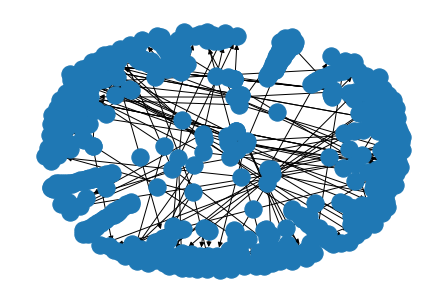

In [114]:
nx.draw(G_simplified, pos=nx.spring_layout(G_simplified))